### Problem statement: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_dir="/content/gdrive/MyDrive/CNN_CASE_STUDY/"
data_dir_train = pathlib.Path(root_dir+"Train/")
data_dir_test = pathlib.Path(root_dir+"Test/")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               batch_size=32,
                                                               image_size=(img_height,img_width),
                                                               seed=123,validation_split=0.2,
                                                               subset="training")


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               batch_size=32,
                                                               image_size=(img_height,img_width),
                                                               seed=123,validation_split=0.2,
                                                               subset="validation")

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

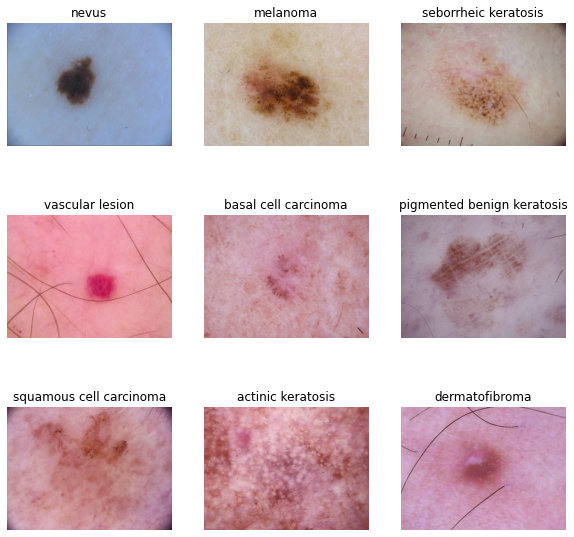

In [9]:
# Since each batch may contain images of same category, iterating through each folder and displaying image
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

count=1
plt.figure(figsize=(10, 10))
for dir_name in data_dir_train.iterdir():
    file_name=list(data_dir_train.joinpath(dir_name).glob('*.jpg'))[0]
    im=PIL.Image.open(file_name)
    ax = plt.subplot(3, 3, count)
    count=count + 1
    plt.imshow(im)
    plt.title(dir_name.name)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
## Creating initial model with 3 convolution +pooling layers, followed by flattenning and dense layers.
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255,input_shape=(img_height, img_width, 3))
num_classes = len(class_names)

model = Sequential([
  normalization_layer,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [14]:
## Training the model with 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 27s 80ms/step - loss: 1.9314 - accuracy: 0.2946 - val_loss: 1.6840 - val_accuracy: 0.4228
Epoch 2/20
56/56 [==============================] - 1s 25ms/step - loss: 1.5971 - accuracy: 0.4291 - val_loss: 1.6207 - val_accuracy: 0.4631
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.4341 - accuracy: 0.4933 - val_loss: 1.4829 - val_accuracy: 0.4810
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3056 - accuracy: 0.5402 - val_loss: 1.3431 - val_accuracy: 0.5391
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.2119 - accuracy: 0.5792 - val_loss: 1.3602 - val_accuracy: 0.5280
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1285 - accuracy: 0.6004 - val_loss: 1.3538 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.0956 - accuracy: 0.6150 - val_loss: 1.4104 - val_accuracy: 0.5503
Epoch 8/20
5

### Visualizing training results

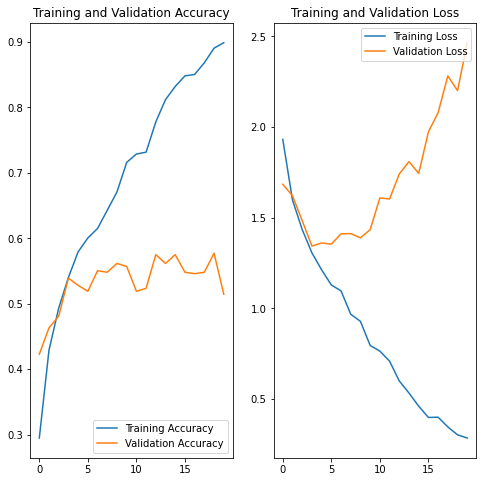

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit



Write your findings here

Observation:
- Training accuracy(89%) is very high while Validation accuracy(51%) is much lesser compared to it.
- Training Loss is decreasing
- Validation loss initially decreased but later started increasing per epoch

The disparity between the accuracy and loss of both training and validation set indicates the model is overfitting.

##

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

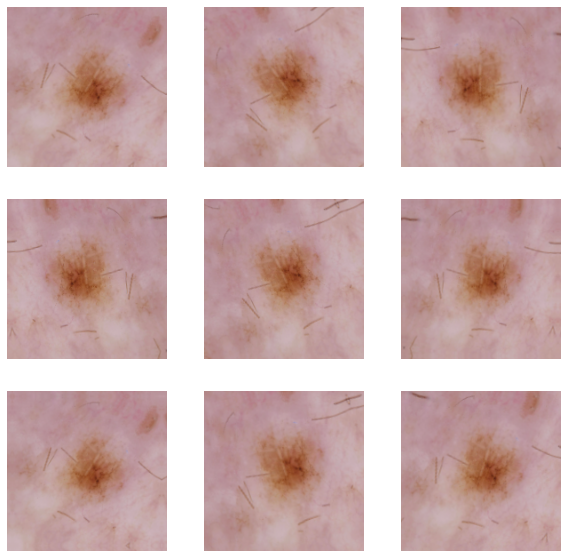

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
model = Sequential([
  data_augmentation,
  normalization_layer,    
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])





### Compiling the model

In [19]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
#history = ## your training code

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 64ms/step - loss: 2.0074 - accuracy: 0.2785 - val_loss: 1.8213 - val_accuracy: 0.3602
Epoch 2/20
56/56 [==============================] - 3s 50ms/step - loss: 1.7240 - accuracy: 0.3666 - val_loss: 1.6052 - val_accuracy: 0.4318
Epoch 3/20
56/56 [==============================] - 2s 42ms/step - loss: 1.5380 - accuracy: 0.4487 - val_loss: 1.4766 - val_accuracy: 0.4676
Epoch 4/20
56/56 [==============================] - 2s 41ms/step - loss: 1.4044 - accuracy: 0.5123 - val_loss: 1.3642 - val_accuracy: 0.5414
Epoch 5/20
56/56 [==============================] - 2s 41ms/step - loss: 1.3715 - accuracy: 0.5173 - val_loss: 1.3450 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 2s 41ms/step - loss: 1.2576 - accuracy: 0.5502 - val_loss: 1.3439 - val_accuracy: 0.5123
Epoch 7/20
56/56 [==============================] - 2s 41ms/step - loss: 1.2556 - accuracy: 0.5413 - val_loss: 1.3498 - val_accuracy: 0.5391
Epoch 8/20
56

### Visualizing the results

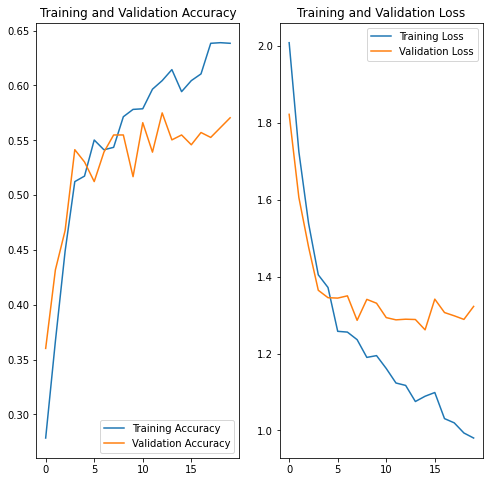

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Observations:
- The disparaity between training and validation accuracy as well as loss has reduced indicating that overfitting has been taken care of but the accuracy percentage is low
- Loss has steadily reduced for both models.
The model is better than the previous model and takes care of overfitting but accuracy values show that they are now underfitting.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

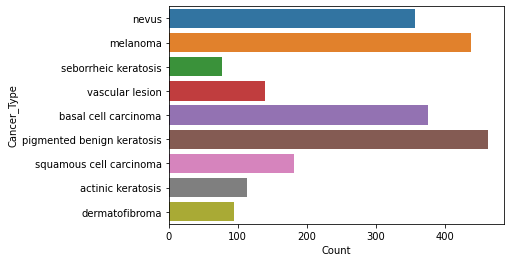

In [22]:
## Retrieving number of images for wach classifcation of cancer from each directory
import pandas as pd
import seaborn as sns
df=[]
count=0
for dir_name in data_dir_train.iterdir():
    df.append({'Cancer_Type':dir_name.name,"Count":len(list(data_dir_train.joinpath(dir_name).glob('*.jpg')))})

    
df=pd.DataFrame(df)

sns.barplot(x=df["Count"],y=df["Cancer_Type"])


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
Answer: The class "seborrheic keratosis" of cancer has less than 100 samples
#### - Which classes dominate the data in terms proportionate number of samples?
Answer: The class "pigmented benign keratosis" of cancer has the maximum number of samples.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [23]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [24]:
path_to_training_dataset=root_dir+"Train/"
import Augmentor
for i in class_names:
    #Output is to kaggle working directory as input does not have write permissions
    p = Augmentor.Pipeline(path_to_training_dataset+i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_CASE_STUDY/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA24672940>: 100%|██████████| 500/500 [00:18<00:00, 26.40 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_CASE_STUDY/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA1F3204F0>: 100%|██████████| 500/500 [00:23<00:00, 21.02 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_CASE_STUDY/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA1F3D8E20>: 100%|██████████| 500/500 [00:26<00:00, 18.84 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_CASE_STUDY/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBB067D9160>: 100%|██████████| 500/500 [01:32<00:00,  5.38 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_CASE_STUDY/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=576x768 at 0x7FBA1FFA2610>: 100%|██████████| 500/500 [01:34<00:00,  5.30 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_CASE_STUDY/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA1FF5E5B0>: 100%|██████████| 500/500 [00:18<00:00, 27.62 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_CASE_STUDY/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FBA24954130>: 100%|██████████| 500/500 [00:41<00:00, 12.04 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_CASE_STUDY/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA1C68BBE0>: 100%|██████████| 500/500 [00:19<00:00, 26.24 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_CASE_STUDY/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBA1F75D940>: 100%|██████████| 500/500 [00:24<00:00, 20.23 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [25]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [26]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN_CASE_STUDY/Train/nevus/output/nevus_original_ISIC_0000528.jpg_894762a7-4b23-4706-8f00-5234b3d0c6ea.jpg',
 '/content/gdrive/MyDrive/CNN_CASE_STUDY/Train/nevus/output/nevus_original_ISIC_0000334.jpg_e5071ca7-78f6-4275-9e07-bbcc5220bfc5.jpg',
 '/content/gdrive/MyDrive/CNN_CASE_STUDY/Train/nevus/output/nevus_original_ISIC_0028941.jpg_16d55730-923a-40a3-9e60-03cdded4f167.jpg',
 '/content/gdrive/MyDrive/CNN_CASE_STUDY/Train/nevus/output/nevus_original_ISIC_0000508.jpg_522f33ce-c9fe-4c1d-8979-804974ea2521.jpg',
 '/content/gdrive/MyDrive/CNN_CASE_STUDY/Train/nevus/output/nevus_original_ISIC_0000409.jpg_d1dab2bc-a944-435d-a1cc-8844910d4bd4.jpg',
 '/content/gdrive/MyDrive/CNN_CASE_STUDY/Train/nevus/output/nevus_original_ISIC_0000360.jpg_7f98e539-8abf-499d-a1dc-a328513456eb.jpg',
 '/content/gdrive/MyDrive/CNN_CASE_STUDY/Train/nevus/output/nevus_original_ISIC_0000385.jpg_537fd55c-37d3-47c9-a248-a5f88e393510.jpg',
 '/content/gdrive/MyDrive/CNN_CASE_STUDY/Train/nevus/ou

In [27]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [28]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [29]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
original_df=[]
for dir_name in data_dir_train.iterdir():
	for filename in list(data_dir_train.joinpath(dir_name).glob('*.jpg')):
		original_df.append({'Path':filename,"Label":dir_name.name})
    
original_df=pd.DataFrame(original_df)

new_df = original_df.append(df2)

In [30]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [31]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [32]:
data_dir_train=path_to_training_dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [33]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [34]:
## your code goes here
model = Sequential([
  normalization_layer,    
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [35]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [36]:
epochs = 30
## Your code goes here, use 50 epochs.
#history = # your model fit code
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 32s 181ms/step - loss: 1.7945 - accuracy: 0.3179 - val_loss: 1.4553 - val_accuracy: 0.4833
Epoch 2/30
169/169 [==============================] - 31s 177ms/step - loss: 1.3681 - accuracy: 0.4841 - val_loss: 1.3557 - val_accuracy: 0.5174
Epoch 3/30
169/169 [==============================] - 31s 176ms/step - loss: 1.1874 - accuracy: 0.5634 - val_loss: 1.0996 - val_accuracy: 0.6251
Epoch 4/30
169/169 [==============================] - 31s 175ms/step - loss: 0.9926 - accuracy: 0.6437 - val_loss: 0.9951 - val_accuracy: 0.6496
Epoch 5/30
169/169 [==============================] - 31s 176ms/step - loss: 0.8152 - accuracy: 0.7025 - val_loss: 0.9181 - val_accuracy: 0.6748
Epoch 6/30
169/169 [==============================] - 30s 174ms/step - loss: 0.6586 - accuracy: 0.7598 - val_loss: 0.7780 - val_accuracy: 0.7157
Epoch 7/30
169/169 [==============================] - 30s 174ms/step - loss: 0.5267 - accuracy: 0.8142 - val_loss: 0.7428 - val_ac

#### **Todo:**  Visualize the model results

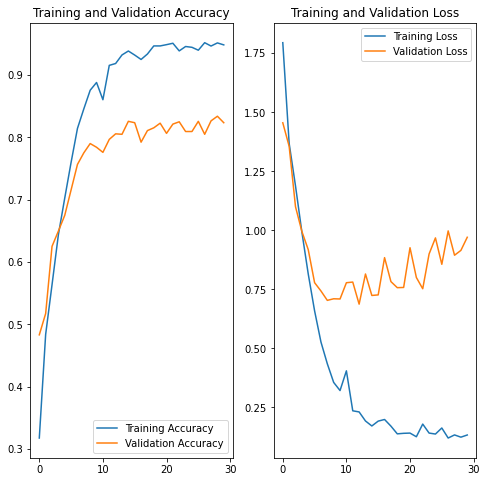

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [44]:
#Evaluate validation dataset
model.evaluate(val_ds)

43/43 [==============================] - 8s 166ms/step - loss: 0.9704 - accuracy: 0.8233


[0.9703679084777832, 0.8233110904693604]

In [45]:
# Test data preprocesing
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [46]:
# Evaluate model on test data
model.evaluate(test_ds)

4/4 [==============================] - 9s 21ms/step - loss: 8.5503 - accuracy: 0.3729


[8.550334930419922, 0.37288135290145874]

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
Observation:
- The class rebalancing helped increase the accuracy by a substantial amount.
- The train accuracy is 94 % while validation accuracy is 81%.
- The disparity is still higher than expected indicating overfitting but this model is better than all other models
- We will need to add more dropouts or regularization to take care of overfitting.



In [47]:
# Predicting one sample using the new model.
melanoma_path = "/content/gdrive/MyDrive/CNN_CASE_STUDY/Test/melanoma/ISIC_0000002.jpg"

img = tf.keras.utils.load_img(
    melanoma_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(score)


1/1 [==============================] - 0s 16ms/step
tf.Tensor(
[8.5966185e-06 2.6018925e-33 1.3917764e-11 1.2672867e-08 9.9999142e-01
 1.7274674e-08 3.7632035e-30 7.5778261e-36 0.0000000e+00], shape=(9,), dtype=float32)


In [48]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(test_ds.class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to nevus with a 100.00 percent confidence.
